Testing the Gaia Challenge simulated data in the case on a non costant or fixed anisotropy in the velocity of the stellar subcomponent. The profile adopted is the Osipkov-Merritt, which reads:
\begin{equation}
\beta(r)=\frac{r^2}{r^2+r^2_a}
\end{equation}
with $r_a = r_h$.

The stellar profile adopted here reads:
\begin{equation}
\nu_\ast(r) = \rho_h \left(\frac{r}{r_h}\right)^{-\gamma_\ast}\left(1+\left(\frac{r}{r_h}\right)^{\alpha_\ast}\right)^\frac{\gamma_\ast-\beta_\ast}{\alpha_\ast}
\end{equation}
with parameters values:
* $\alpha_\ast$ = 2
* $\beta_\ast$ = 5
* $r_h$ = 0.1,0.25,1 kpc

leading to the simple expression
\begin{equation}
\nu_\ast(r) = \frac{\rho_h}{\left(\frac{r}{r_h}\right)^{\gamma_\ast}\left(1+\left(\frac{r}{r_h}\right)^2\right)^{\frac{5-\gamma_\ast}{2}}}
\end{equation}

for $\gamma_\ast = 0.1,1$ this is referred to as "Plummer" and "non-Plummer" stellar profile, respectively.

In the non-Plummer profile case, the surface brightness profile has the following analytic expression:
\begin{equation}
I(R) = 2 \int^\infty_R \frac{\nu_\ast(r) r dr}{\sqrt{r^2-R^2}} = \rho_h \frac{r_h^2\left[(2r_h^2+R^2) csch^{-1}\left(\frac{R}{r_h}\right) - r_h\sqrt{r_h^2+R^2}\right]}{(r_h^2+R^2)^{3/2}}
\end{equation}

The $line-of-sight$ velocity dispersion $\sigma^2(R)$ that enters the Likelihood has the following expression
\begin{equation}
\sigma^2_{l.o.s.}(R) = 2G\mu_0\frac{R}{I(R)}\int^\infty_1 \left(1+\frac{\beta(zR)}{z^2}\right)\frac{z}{\sqrt{z^2-1}}\int^\infty_{zR}\left(\frac{s}{zR}\right)^{2\beta(s)}\frac{\nu_\ast(s)\mu(s/r_0)}{s^2}dsdz
\end{equation}

In [1]:
import yaml
import numpy as np
from os import mkdir
from sys import argv
from AT import get_data
from scipy import special
from matplotlib import pylab as plt
from scipy.integrate import quad
from math import sqrt,cos, log10, pi
from scipy import optimize as sciopt
from scipy.interpolate import UnivariateSpline as spline
from scipy.interpolate import interp1d as interp
from functions_simOM import integral2, Jfactor,nu
from multiprocessing import Pool
%matplotlib inline

In [2]:
# enter size of Mock dataset (options 100,1000,10000)
MockSize = 100
include_err = 'no'

In [3]:
# inverse hyperbolic cosecant (used for gamma* = 1 , non-Plum)
def inv_csch(x):
    return np.log(np.sqrt(1+x**-2.)+x**-1.)
# integrand of I(R) (used for gamma* = 0.1 , Plum)
def integrand_I(r,rh,R):
    return nu(r,rh)*r/np.sqrt(r**2-R**2)

# dwarf surface brightness profile
def I(R,rh):
    return rh**2*((2*rh**2+R**2)*inv_csch(R/rh)-rh*np.sqrt(rh**2+R**2))/(rh**2+R**2)**(3/2.) # for gamma*=1 , non-Plum
    #return 2*quad(integrand_I,R,+np.inf,args=(rh,R))[0] # for gamma*=0.1 , Plum

In [4]:
# Mock data preparation
homedir = '/home/andrea/Desktop/work/DWARF/Jvalue/output/test/'
casedir = 'OsipkMerr+Core+nonPlum'
data = '/gs100_bs050_rcrs025_rarc100_core_0400mpc3_df_%i_0.dat'%MockSize
err  = '/gs100_bs050_rcrs025_rarc100_core_0400mpc3_df_%i_0_err.dat'%MockSize
x,y,z,vx,vy,vz = np.loadtxt(homedir+casedir+data,unpack=True)
R = np.sqrt(x**2+y**2) # assumed direction of observation along z-axis for simplicity (as suggested on the Gaia wiki)
D=50.
d = np.sqrt(x**2+y**2+(D-z)**2)
v = (x*vx+y*vy+(D-z)*vz)/d
# Errors (from mock data) preparation
Evx,Evy,Evz = np.loadtxt(homedir+casedir+err,unpack=True,usecols=(3,4,5))
Ex,Ey,Ez = np.absolute(Evx-vx),np.absolute(Evy-vy),np.absolute(Evz-vz)
Ev = (x*Ex+y*Ey+(D-z)*Ez)/d

In [6]:
u=0.
rh=0.25
nstars=np.size(R)
errors = {'yes':True,'no':False}
if errors[include_err]:
    dv = Ev
else:
    dv = np.zeros_like(R)

In [7]:
A_array = np.array([Ri/I(Ri,rh) for Ri in R])
ra_array = np.logspace(-3.,1.,100)
r0_array = np.logspace(-2.,2.,100)
I_array=np.zeros(shape=(len(A_array),len(ra_array),len(r0_array)))

In [150]:
def array_builder(r0_array, ra_array, R_array):
    for i,R in enumerate(R_array):
        for j,ra in enumerate(ra_array):
            for k,r0 in enumerate(r0_array):
                yield (i, j, k), (R, ra, rh, r0)

def proxy(args):
    return args[0], integral2(*args[1])*A_array[args[0][0]]

In [151]:
pool = Pool(processes=4)
results = pool.map(proxy, array_builder(r0_array, ra_array, R))
pool.close()
pool.join()
for idx,value in results:
    I_array[idx] = value

In [14]:
#np.save('Iarray_32',I_array)
I_array = np.load('Iarray.npy')

In [15]:
cst = 8.*np.pi*4.3e-6
# Likelihood definition (for free beta)
def logLike(M0,i,j):
    I = cst*M0*I_array[:,i,j]
    S = dv**2.+I
    res = (np.log(S) + (v-u)**2./S).sum()
    return res/2.

In [16]:
# |J-J(rho0,r0)| for J inversion (in log scale)
log10Jrho1 = np.log10([Jfactor(D,np.inf,r0,1.,0.5) for r0 in r0_array])
def deltaJ(log10rho0,log10J,j):
    return abs(log10J-log10Jrho1[j]-2*log10rho0)

(0.001, 100.0)

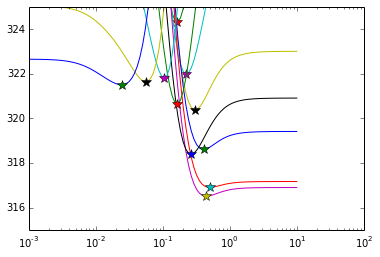

In [18]:
J_array = np.linspace(19,21,10)
LikeJ = np.zeros_like(ra_array)
J_new = np.empty([0])
min_LikeJ = np.empty([0])
min_ra_arr = np.empty([0])
for J in [21]:#J_array:
    LikeJbeta = np.empty([0])
    r0_new = np.empty([0])
    ra_new = np.empty([0])
    #for j,r0 in enumerate(r0_array):
    index = range(0,100,5)#[0,5,10,20,30,40,50,60,70,80,-1]
    array = [r0_array[i] for i in index]
    for j,r0 in zip(index,array):
        log10rho0 = sciopt.minimize_scalar(deltaJ,args=(J,j)).x
        for i,ra in enumerate(ra_array):
            LikeJ[i] = logLike(10**log10rho0*r0**3,i,j)
        spline_LikeBeta = spline(ra_array,LikeJ,s=0)
        min_ra = sciopt.minimize_scalar(spline_LikeBeta,method='Bounded',bounds=(ra_array[0],ra_array[-1]))
        if ra_array[1]<min_ra.x<ra_array[-2]:
            r0_new = np.append(r0_new,r0)
            ra_new = np.append(ra_new,min_ra.x)
            LikeJbeta = np.append(LikeJbeta,min_ra.fun)
            plt.semilogx(ra_array,spline_LikeBeta(ra_array),label=r'$r_0$=%.2f'%r0)
            plt.plot(min_ra.x,min_ra.fun,'*',markersize=10)
    '''
    if len(r0_new)>3:
        spline_ra = spline(r0_new,ra_new,s=0)
        spline_LikeJ = spline(r0_new,LikeJbeta,s=0)
        plt.semilogx(r0_new,spline_LikeJ(r0_new))
        min_r0 = sciopt.minimize_scalar(spline_LikeJ)#,method='Bounded',
                                         #bounds=(r0_new[0],r0_new[np.size(r0_new)/2]))
        plt.plot(min_r0.x,min_r0.fun,'*',markersize=10,c='k')
    
        min_r0L = sciopt.minimize_scalar(spline_LikeJ,method='Bounded',
                                         bounds=(r0_new[0],r0_new[np.size(r0_new)/2]))
        min_r0R = sciopt.minimize_scalar(spline_LikeJ,method='Bounded',
                                         bounds=(r0_new[np.size(r0_new)/2],r0_new[-1]))
        if min_r0R.fun>min_r0L.fun:
            if r0_new[1]<min_r0L.x<r0_new[-2]:
                plt.semilogx(r0_new,spline_LikeJ(r0_new),label='J=%.4f'%J)
                plt.plot(min_r0L.x,min_r0L.fun,'*',markersize=10,c='k')
                J_new = np.append(J_new,J)
                min_LikeJ = np.append(min_LikeJ,min_r0L.fun)
                min_ra_arr = np.append(min_ra_arr,spline_ra(min_r0L.x))
        else:
            if r0_new[1]<min_r0R.x<r0_new[-2]:
                plt.semilogx(r0_new,spline_LikeJ(r0_new),label='J=%.4f'%J)
                plt.plot(min_r0R.x,min_r0R.fun,'*',markersize=10,c='k')
                J_new = np.append(J_new,J)
                min_LikeJ = np.append(min_LikeJ,min_r0R.fun)
                min_ra_arr = np.append(min_ra_arr,spline_ra(min_r0R.x))
        ''''''
        min_r0L = sciopt.minimize_scalar(spline_LikeJ,method='Bounded',
                                         bounds=(r0_new[0],r0_new[np.size(r0_new)/3]))
        min_r0C = sciopt.minimize_scalar(spline_LikeJ,method='Bounded',
                                         bounds=(r0_new[np.size(r0_new)/3],r0_new[np.size(r0_new)*2/3]))
        min_r0R = sciopt.minimize_scalar(spline_LikeJ,method='Bounded',
                                         bounds=(r0_new[np.size(r0_new)*2/3],r0_new[-1]))
        if min_r0L.fun<min_r0C.fun and min_r0L.fun<min_r0R.fun:
            if r0_new[1]<min_r0L.x<r0_new[-2]:
                plt.semilogx(r0_new,spline_LikeJ(r0_new),label='J=%.4f'%J)
                plt.plot(min_r0L.x,min_r0L.fun,'*',markersize=10,c='k')
                J_new = np.append(J_new,J)
                min_LikeJ = np.append(min_LikeJ,min_r0L.fun)
                min_ra_arr = np.append(min_ra_arr,spline_ra(min_r0L.x))
        if min_r0C.fun<min_r0L.fun and min_r0C.fun<min_r0R.fun:
            if r0_new[1]<min_r0C.x<r0_new[-2]:
                plt.semilogx(r0_new,spline_LikeJ(r0_new),label='J=%.4f'%J)
                plt.plot(min_r0C.x,min_r0C.fun,'*',markersize=10,c='k')
                J_new = np.append(J_new,J)
                min_LikeJ = np.append(min_LikeJ,min_r0C.fun)
                min_ra_arr = np.append(min_ra_arr,spline_ra(min_r0C.x))
        if min_r0R.fun<min_r0L.fun and min_r0R.fun<min_r0C.fun:
            if r0_new[1]<min_r0R.x<r0_new[-2]:
                plt.semilogx(r0_new,spline_LikeJ(r0_new),label='J=%.4f'%J)
                plt.plot(min_r0R.x,min_r0R.fun,'*',markersize=10,c='k')
                J_new = np.append(J_new,J)
                min_LikeJ = np.append(min_LikeJ,min_r0R.fun)
                min_ra_arr = np.append(min_ra_arr,spline_ra(min_r0R.x))
        '''
plt.ylim(315,325)
#plt.xlim(1e-3,1e2)
#plt.legend(bbox_to_anchor=(1.4,1))

In [150]:
spline_Like = spline(J_new,min_LikeJ)
min_J = sciopt.minimize_scalar(spline_Like,method='Bounded',bounds=(J_new[0],J_new[-1])).x
spline_Like_ra = spline(J_new,min_ra_arr)
min_ra = spline_Like_ra(min_J)

error: (m>k) failed for hidden m: fpcurf0:m=0

In [ ]:
print 'min J = ',round(min_J,2),'ra = ',round(min_ra,2)

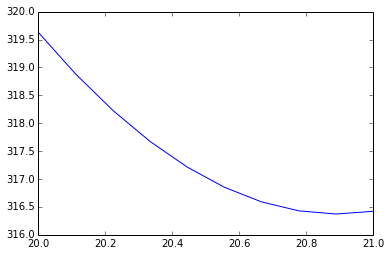

In [83]:
plt.plot(J_new,spline_Like(J_new))
#plt.xlim(19.1,19.4)

In [84]:
def one_sigmaJ(J):
    return np.abs(spline_Like(J)-spline_Like(min_J)-0.5)

one_sigma_l = sciopt.minimize_scalar(one_sigmaJ,method='Bounded',bounds=(J_new[0],min_J)).x-min_J
one_sigma_r = sciopt.minimize_scalar(one_sigmaJ,method='Bounded',bounds=(min_J,J_new[-1])).x-min_J

def two_sigmaJ(J):
    return np.abs(spline_Like(J)-spline_Like(min_J)-2.)

two_sigma_l = sciopt.minimize_scalar(two_sigmaJ,method='Bounded',bounds=(J_new[0],min_J)).x-min_J
two_sigma_r = sciopt.minimize_scalar(two_sigmaJ,method='Bounded',bounds=(min_J,J_new[-1])).x-min_J

def three_sigmaJ(J):
    return np.abs(spline_Like(J)-spline_Like(min_J)-4.)

three_sigma_l = sciopt.minimize_scalar(three_sigmaJ,method='Bounded',bounds=(J_new[0],min_J)).x-min_J
three_sigma_r = sciopt.minimize_scalar(three_sigmaJ,method='Bounded',bounds=(min_J,J_new[-1])).x-min_J

In [85]:
print round(min_J,2),round(one_sigma_l,2),round(one_sigma_r,2),round(two_sigma_l,2),\
round(two_sigma_r,2),round(three_sigma_l,2),round(three_sigma_r,2)

20.89 -0.35 0.11 -0.7 0.11 -0.89 0.11


In [86]:
trueJ = round(np.log10(Jfactor(D,np.inf,1.,4e8,0.5)),2)
print 'true J : ',trueJ,', obtained J : ',round(min_J,2)

true J :  20.95 , obtained J :  20.89


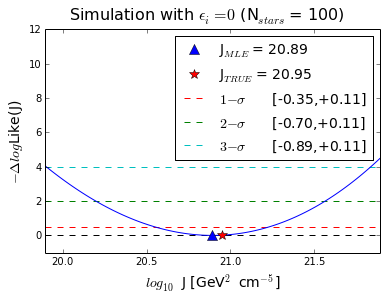

In [87]:
J_plt = np.linspace(min_J-1,min_J+1,100)
plt.plot(J_plt,spline_Like(J_plt)-spline_Like(min_J))
plt.plot(min_J,0,'b^',markersize=10,label='J$_{MLE}$ = %.2f'%min_J)
plt.plot(trueJ,0,'r*',markersize=10,label='J$_{TRUE}$ = %.2f'%trueJ)
plt.hlines(0.,min(J_plt),max(J_plt),linestyles='dashed')
plt.hlines(.5,min(J_plt),max(J_plt),colors=('r'),linestyles='dashed',
           label=r'$1-\sigma$'+'\t'+'[%.2f,%+.2f]'%(one_sigma_l,one_sigma_r))
plt.hlines(2,min(J_plt),max(J_plt),colors=('g'),linestyles='dashed',
           label=r'$2-\sigma$'+'\t'+'[%.2f,%+.2f]'%(two_sigma_l,two_sigma_r))
plt.hlines(4,min(J_plt),max(J_plt),colors=('c'),linestyles='dashed',
           label=r'$3-\sigma$'+'\t'+'[%.2f,%+.2f]'%(three_sigma_l,three_sigma_r))
plt.legend(numpoints=1,fontsize=14)
plt.ylabel(r'$-\Delta$$log$Like(J)',fontsize=14)
plt.xlabel(r'$log_{10}$  J [GeV$^2$ cm$^{-5}$]',fontsize=14)
plt.ylim(-1,12)
plt.xlim(min_J-1,min_J+1)
if errors[include_err]:
    plt.suptitle(r'Simulation with $\epsilon_i \neq 0$ (N$_{stars}$ = %i)'%nstars,fontsize=16)
    plt.savefig('/home/andrea/Desktop/work/DWARF/Jvalue/output/test/OsipkMerr+Cusp+nonPlum/Simulation%ierr.png'%nstars,
                dpi=300,format='png')
else:
    plt.suptitle(r'Simulation with $\epsilon_i = 0$ (N$_{stars}$ = %i)'%nstars,fontsize=16)
    plt.savefig('/home/andrea/Desktop/work/DWARF/Jvalue/output/test/OsipkMerr+Cusp+nonPlum/Simulation%i.png'%nstars,
                dpi=300,format='png')

In [96]:
print '%.2e'%10**sciopt.minimize_scalar(lambda log10rho0:abs(min_J-
                                                             np.log10(Jfactor(D,np.inf,1.,1.,0.5))-2*log10rho0)).x

8.08e+07
